In [1]:
%reset -f

%load_ext autoreload
%autoreload 2

# Polar Json converter

Last updated by AKR (7/25/24).

- This notebook converts "manually exported" Polar json files into csv files named:

    f"{participant id}\_{polar workout number (pwo)}\_{day since start}_hr_WearablePolar_Polar.csv" 



- Each csv file represents an individual workout, with columns for dateTime and (HR) values.

### Load packages

In [11]:
import random
import os, glob
import pandas as pd
from datetime import datetime, timedelta
import json 
from IPython.display import display, HTML
import matplotlib.pyplot as plt

#initialization
random.seed(1000)

### Get data from REDCap

In [12]:
base_path = '/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/Redcap/Raw_Data/'
file_red = '64208_HRZones_Raw.csv' # columns of this file: record_id, redcap_event_name, enrollment_status, myphd_id, myphd_date_shift, randomization_group, bl_heart_rate_mict, bl_heart_rate_hiit, workout_1, polar_1, fitbit_1, workout_2

# Reads csv
df_red = pd.read_csv(f"{base_path}{file_red}")
df_red.dropna(subset=['myphd_id', 'randomization_group'], inplace=True)

# Drop unnecessary columns
df_red = df_red.drop(df_red.columns[[0, 2]], axis=1)
# df_red

In [13]:
# Reads csv
notes_path = '/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/Redcap/Raw_Data/64208_WorkoutTimeStamps_Raw.csv'
# columns of this file:
#record_id	redcap_event_name	data_collection_start_date	data_collection_end_date	workout_1	borg_rpe_1	polar_1	fitbit_1	heartrate_1	duration_1	why_heartrate1	notes_1	workout_2	borg_rpe_2	polar_2	fitbit_2	heartrate_2	duration_2	why_heartrate2	notes_2	workout_3	borg_rpe_3	polar_3	fitbit_3	heartrate_3	duration_3	why_heartrate3	notes_3	admin_inperson_workouts	admin_workout_attempts	admin_num_success_workouts	admin_reasons_for_non_adherence___2	admin_reasons_for_non_adherence___3	admin_reasons_for_non_adherence___4	admin_reasons_for_non_adherence___5	admin_reasons_for_non_adherence___6	admin_reasons_for_non_adherence___99	admin_notes

df_notes_orig = pd.read_csv(f"{notes_path}")
df_notes= df_notes_orig.copy()

df_notes['workout_1'] = pd.to_datetime(df_notes['workout_1'])
df_notes['workout_2'] = pd.to_datetime(df_notes['workout_2'])
df_notes['workout_3'] = pd.to_datetime(df_notes['workout_3'])

df_notes['workout1_date_only'] = df_notes['workout_1'].dt.strftime("%Y-%m-%d")
df_notes['workout2_date_only'] = df_notes['workout_2'].dt.strftime("%Y-%m-%d")
df_notes['workout3_date_only'] = df_notes['workout_3'].dt.strftime("%Y-%m-%d")

# df_notes

### Function to gets files for a participant

In [14]:
def get_files(participant):
    json_path = f"/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar_recovery/{participant}/polar-user-data-export_{participant}/"
    os.chdir(json_path)
    files = []
    for file in glob.glob("training-session*.json"):
        files.append(file)
    original_files = files.copy()
    files = sorted(files)
    print("There are", len(files), "files for", participant)
    return files


# get_files("004_qtz1b18445579426718188")

In [15]:
import os
import glob
import json
import pandas as pd
from datetime import timedelta

def convert_json_to_csv(participant):
    # Extract files from Google Drive
    json_path = f"/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar_recovery/{participant}/polar-user-data-export_{participant}/"
    os.chdir(json_path)
    files = []
    for file in glob.glob("training-session*.json"):
        files.append(file)
    original_files = files.copy()
    files = sorted(files)
    print(f"There are {len(files)} files for {participant}")

    # Load redcap data
    df_path = '/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/Redcap/Raw_Data/64208_HRZones_Raw.csv'
    df_red = pd.read_csv(df_path)

    try:
        participant_aux = participant.split('_')[1]
    except IndexError:
        participant_aux = None

    if participant_aux:
        participant_info = df_red[df_red['myphd_id'] == participant_aux]['record_id'].iloc[0]

    for file in files:
        full_file_name = os.path.join(json_path, file)

        # Read JSON data from the file and store it as a string
        with open(full_file_name, 'r') as file2read:
            json_data = file2read.read()

        data_dict = json.loads(json_data)
        exercises = data_dict['exercises']

        try:
            df_hr = pd.DataFrame(exercises[0]['samples']['heartRate'])
        except KeyError:
            continue  # Skip this file if 'heartRate' data is not present

        df_hr['dateTime'] = pd.to_datetime(df_hr['dateTime'])

        if df_hr['dateTime'].max() - df_hr['dateTime'].min() > timedelta(minutes=10):
            date_info = df_hr['dateTime'].iloc[0].strftime("%Y-%m-%d")

            # Assuming df_notes is defined and loaded somewhere in your script
            wo1_df = df_notes[(df_notes['record_id'] == participant_info) & (df_notes['workout1_date_only'] == date_info)]
            wo2_df = df_notes[(df_notes['record_id'] == participant_info) & (df_notes['workout2_date_only'] == date_info)]
            wo3_df = df_notes[(df_notes['record_id'] == participant_info) & (df_notes['workout3_date_only'] == date_info)]

            if len(wo1_df) > 0:
                train_week_info = wo1_df['redcap_event_name'].iloc[0]
                workout_export = ""
            elif len(wo2_df) > 0:
                train_week_info = wo2_df['redcap_event_name'].iloc[0]
                workout_export = ""
            elif len(wo3_df) > 0:
                train_week_info = wo3_df['redcap_event_name'].iloc[0]
                workout_export = ""
            else:
                train_week_info = 'week_NotInRedcap_recorded'
                workout_export = "NEED_QC_CHECK"

            output_path = f"/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar/workout/{participant}/"
            output_name = f"{participant_info:03}_{date_info}_{workout_export}_{participant_aux}_hr_WearablePolar_Polar.csv"

            if not os.path.exists(output_path):
                os.makedirs(output_path)

            fullname = os.path.join(output_path, output_name)
            df_hr.to_csv(fullname, index=False)
            print(f"CSV file saved: {fullname}")

    print("Processing complete.")


### Polar json converter function V1

In [16]:
convert_json_to_csv("046_qtz1b12637499885254663")

There are 39 files for 046_qtz1b12637499885254663
CSV file saved: /Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar/workout/046_qtz1b12637499885254663/046_2023-08-21__qtz1b12637499885254663_hr_WearablePolar_Polar.csv
CSV file saved: /Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar/workout/046_qtz1b12637499885254663/046_2023-08-24__qtz1b12637499885254663_hr_WearablePolar_Polar.csv
CSV file saved: /Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar/workout/046_qtz1b12637499885254663/046_2023-08-26__qtz1b12637499885254663_hr_WearablePolar_Polar.csv
CSV file saved: /Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar/workout/046_qtz1b12637499885254663/046_2023-08-28__qtz1b12637499885254663_hr_WearablePolar_Polar.csv
CSV file saved: /Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar/workout/046_qtz1b12637499885254663/046_2023-08

# 7/24/24
Useful items


In [17]:
# Specify participant
participant = "046_qtz1b12637499885254663"

# Load redcap data for that participant
df_path = '/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/Redcap/Raw_Data/64208_HRZones_Raw.csv'
df_red = pd.read_csv(df_path)
participant_data = df_red[df_red["myphd_id"]==participant.split('_')[1]] # get redcap row where qtzmyphdid matches the string in participant 046_qtz...
participant_data

# Load notes data
notes_path = '/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/Redcap/Raw_Data/64208_WorkoutTimeStamps_Raw.csv'
# columns of this file:
#record_id	redcap_event_name	data_collection_start_date	data_collection_end_date	workout_1	borg_rpe_1	polar_1	fitbit_1	heartrate_1	duration_1	why_heartrate1	notes_1	workout_2	borg_rpe_2	polar_2	fitbit_2	heartrate_2	duration_2	why_heartrate2	notes_2	workout_3	borg_rpe_3	polar_3	fitbit_3	heartrate_3	duration_3	why_heartrate3	notes_3	admin_inperson_workouts	admin_workout_attempts	admin_num_success_workouts	admin_reasons_for_non_adherence___2	admin_reasons_for_non_adherence___3	admin_reasons_for_non_adherence___4	admin_reasons_for_non_adherence___5	admin_reasons_for_non_adherence___6	admin_reasons_for_non_adherence___99	admin_notes

df_notes_orig = pd.read_csv(f"{notes_path}")
df_notes= df_notes_orig.copy()

df_notes['workout_1'] = pd.to_datetime(df_notes['workout_1'])
df_notes['workout_2'] = pd.to_datetime(df_notes['workout_2'])
df_notes['workout_3'] = pd.to_datetime(df_notes['workout_3'])

df_notes['workout1_date_only'] = df_notes['workout_1'].dt.strftime("%Y-%m-%d")
df_notes['workout2_date_only'] = df_notes['workout_2'].dt.strftime("%Y-%m-%d")
df_notes['workout3_date_only'] = df_notes['workout_3'].dt.strftime("%Y-%m-%d")


# Extract files for participant
def get_files(participant):
    json_path = f"/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar_recovery/{participant}/polar-user-data-export_{participant}/"
    os.chdir(json_path)
    files = []
    for file in glob.glob("training-session*.json"):
        files.append(file)
    original_files = files.copy()
    files = sorted(files)
    print("There are", len(files), "files for", participant) 
    return(files)

get_files("046_qtz1b12637499885254663")

There are 39 files for 046_qtz1b12637499885254663


['training-session-2023-08-16-7768865871-9a18a11b-3b07-43e6-8853-8423bab63d23.json',
 'training-session-2023-08-16-7768865892-ca7e91da-8ad4-4ec5-98b9-378849e68f52.json',
 'training-session-2023-08-21-7768865846-a456e220-ef80-4528-b3b9-22fe38e44175.json',
 'training-session-2023-08-24-7768865825-dc134ab9-0320-4813-b853-cb8015e87b1d.json',
 'training-session-2023-08-26-7768865806-4ac3ec89-3bb5-4432-8abd-2d741a732aa3.json',
 'training-session-2023-08-28-7768865783-ed7936e1-f273-4bde-8f17-e4551db9530c.json',
 'training-session-2023-08-30-7768865765-27c69ad1-4316-4198-b3e5-82c4eb68243b.json',
 'training-session-2023-09-02-7768865747-a1658bd6-72d4-4966-8047-220bc5183f44.json',
 'training-session-2023-09-05-7768865723-b5ab4975-f9af-4671-a610-02b17fea280d.json',
 'training-session-2023-09-07-7768865680-cab2d9c6-4e8d-4cee-b1a2-f47d1d265ab5.json',
 'training-session-2023-09-07-7768865702-8e365eed-cf51-4d42-8cd7-dd926c2f0581.json',
 'training-session-2023-09-09-7768865656-5d5b0f8a-95b9-4e07-b29c-

## Polar json converter (aubrey - make into function in next code block)

In [18]:
# Specify participant
participant = "046_qtz1b12637499885254663"

# Load workout annotations from REDCap
notes_path = '/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/Redcap/Raw_Data/64208_WorkoutTimeStamps_Raw.csv'
df_notes_orig = pd.read_csv(f"{notes_path}")
df_notes= df_notes_orig.copy()

df_notes['workout_1'] = pd.to_datetime(df_notes['workout_1'])
df_notes['workout_2'] = pd.to_datetime(df_notes['workout_2'])
df_notes['workout_3'] = pd.to_datetime(df_notes['workout_3'])

df_notes['workout1_date_only'] = df_notes['workout_1'].dt.strftime("%Y-%m-%d")
df_notes['workout2_date_only'] = df_notes['workout_2'].dt.strftime("%Y-%m-%d")
df_notes['workout3_date_only'] = df_notes['workout_3'].dt.strftime("%Y-%m-%d")

# Get files
json_path = f"/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar_recovery/{participant}/polar-user-data-export_{participant}/"
os.chdir(json_path)
files = []
for file in glob.glob("training-session*.json"):
    files.append(file)
    original_files = files.copy()
    files = sorted(files)


# For each each json file, extract HR data; save as a csv file in Google Drive.
i=0
counter=0
qc_checks=0
for i, file in enumerate(files):

    # Get full path to file
    full_file_name = f"{json_path}{file}"

    # Read JSON data from the file and store it as a string
    with open(full_file_name, 'r', ) as file2read:
        json_data = file2read.read()
        file2read.close()

    # Parse json into a data dictionary with json.loads()
    data_dict = json.loads(json_data)

    # Extract key of interest
    exercises = data_dict['exercises']

    # GET THE DATA FROM POLAR FILE (Extract values, convert to dataframe)
    df_hr = pd.DataFrame(exercises[0]['samples']['heartRate'])
    # Convert time column to datetime type
    df_hr['dateTime'] = pd.to_datetime(df_hr['dateTime'])
    
    # ENRICH WITH METADATA
    # 1) Extract date of each workout as a string
    date_info = df_hr['dateTime'].iloc[0].strftime("%Y-%m-%d")
    # Convert string to date
    workout_date = pd.to_datetime(date_info).date()

    # 2) Get redcap start date for each ppt
    participant_num = int(participant.split('_')[0]) # Get ppt number from polar file
    start_date_str = df_notes.loc[(df_notes['redcap_event_name'] == 'week_1_arm_1') & (df_notes['record_id'] == participant_num), 'workout_1'].values[0]
    # Convert string to date
    start_date = pd.to_datetime(start_date_str).date()
    
    # 3) Compare date of workout to redcap start date
    delta = workout_date - start_date
    days_str = str(delta.days)
    day = f'd{days_str}'
    print(workout_date)

    # 4) See if Polar date is recorded in REDCap. If yes, then label as workout i; else, write QC_Check
    if df_hr['dateTime'].max() - df_hr['dateTime'].min() > timedelta(minutes=10):
        
        wo1_df = df_notes[(df_notes['record_id']==participant_info) & (df_notes['workout1_date_only']==date_info)] 
        wo2_df = df_notes[(df_notes['record_id']==participant_info) & (df_notes['workout2_date_only']==date_info)] 
        wo3_df = df_notes[(df_notes['record_id']==participant_info) & (df_notes['workout3_date_only']==date_info)]

        if len(wo1_df)>0 or len(wo2_df)>0 or len(wo3_df)>0:
            counter += 1
            workout_num = f'pwo{counter}'
            
        else:
            qc_checks += 1
            workout_num = "QC-CHECK"
        
        #print(workout_num)
            
        # 5) Rename file with metadata
        wo_info = f'{workout_num}_{day}'

        output_path = f"/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar/workout/{participant}/"

        output_name = f"{participant.split('_')[0]}_{wo_info}_hr_WearablePolar_Polar.csv" 

        # 6) Save to drive
        if not os.path.exists(output_path):  
                os.mkdir(output_path) 
        fullname = os.path.join(output_path, output_name)      

        df_hr.to_csv(fullname, index=False)

        print(f"CSV file saved: {fullname}")

print("Processing complete.")
print(f'Participant {participant_num}: {counter} workouts logged, with {qc_checks} extra files to QC CHECK')

start_date

2023-08-16
2023-08-16
2023-08-21


NameError: name 'participant_info' is not defined

## Plot the QC check files

46


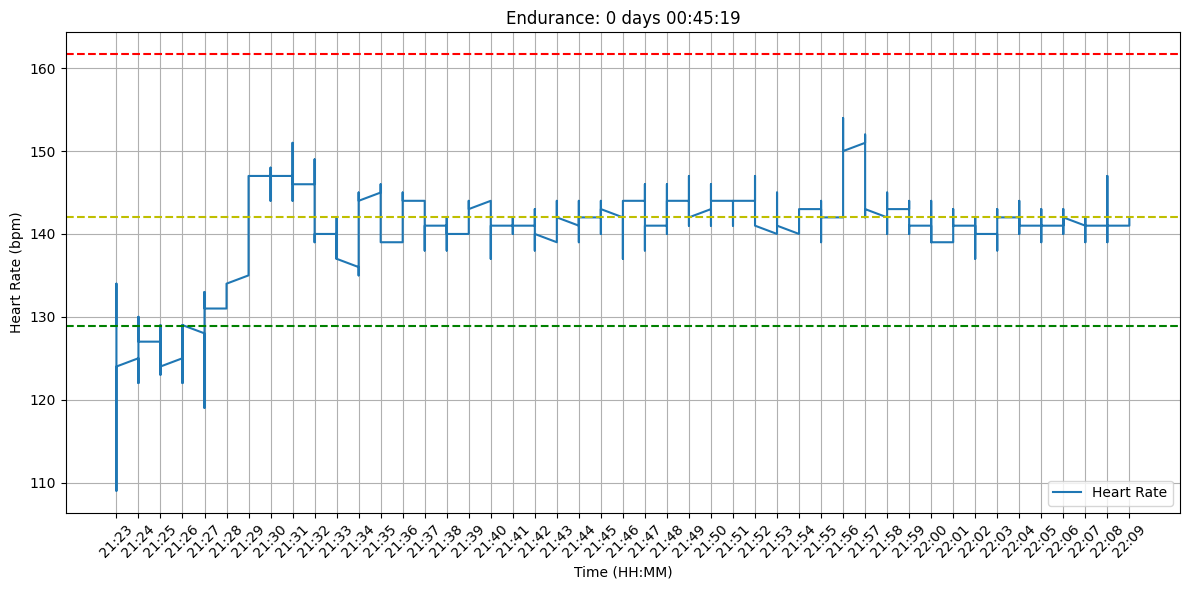

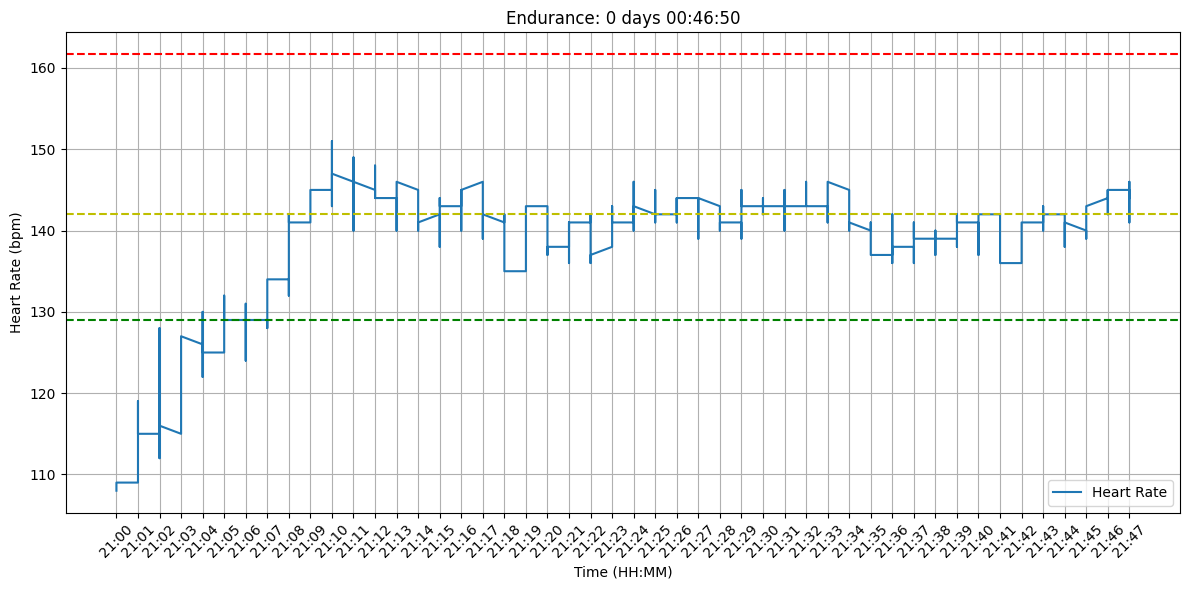

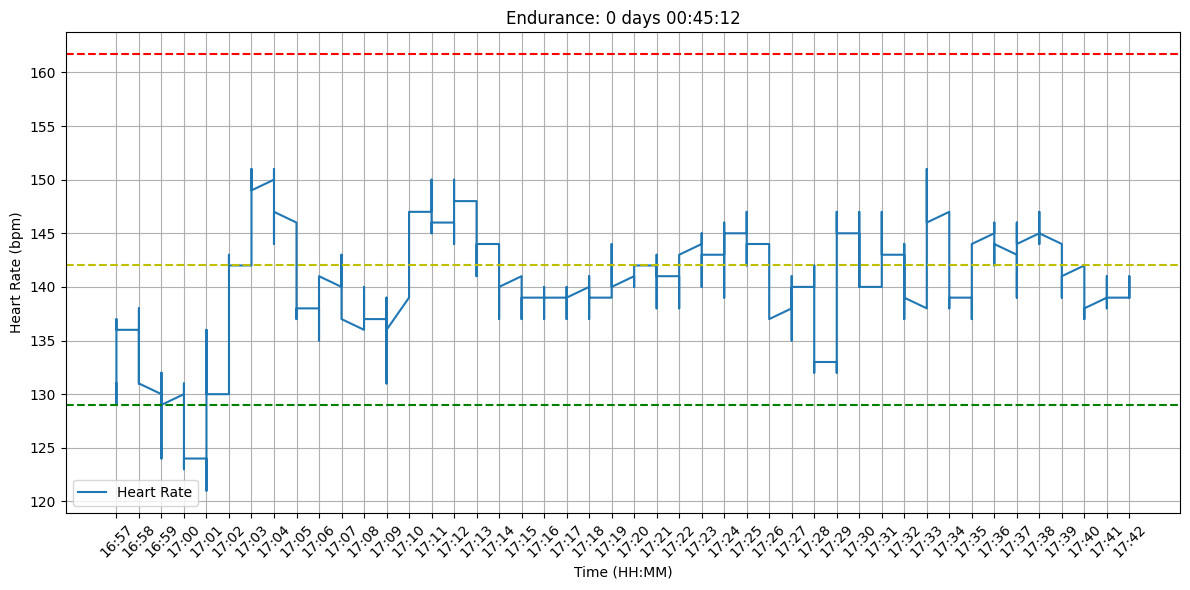

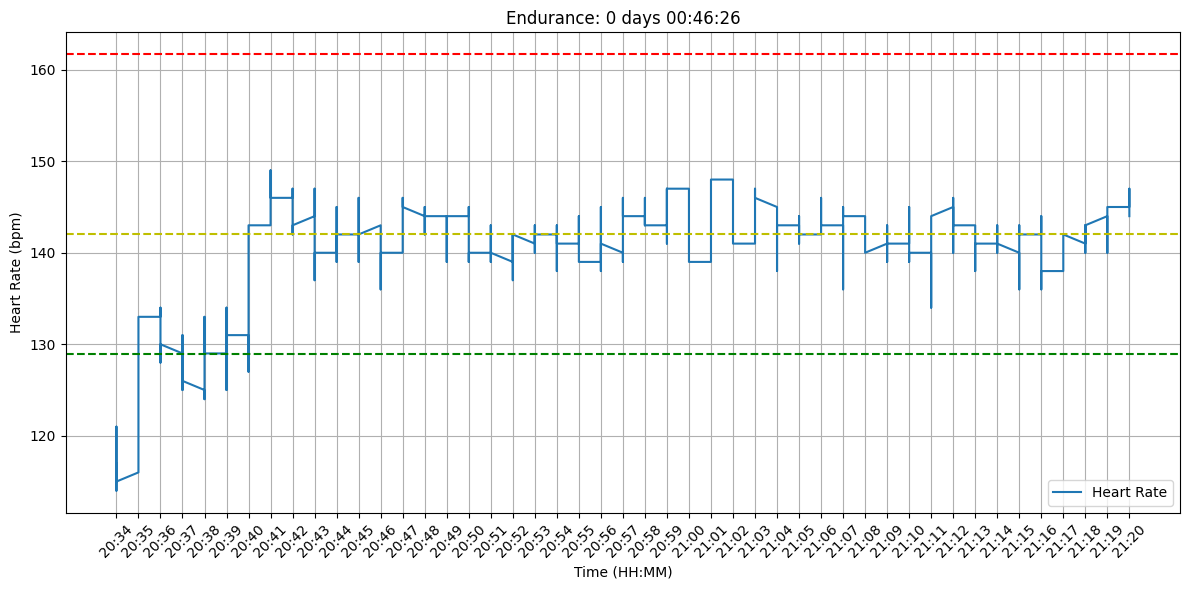

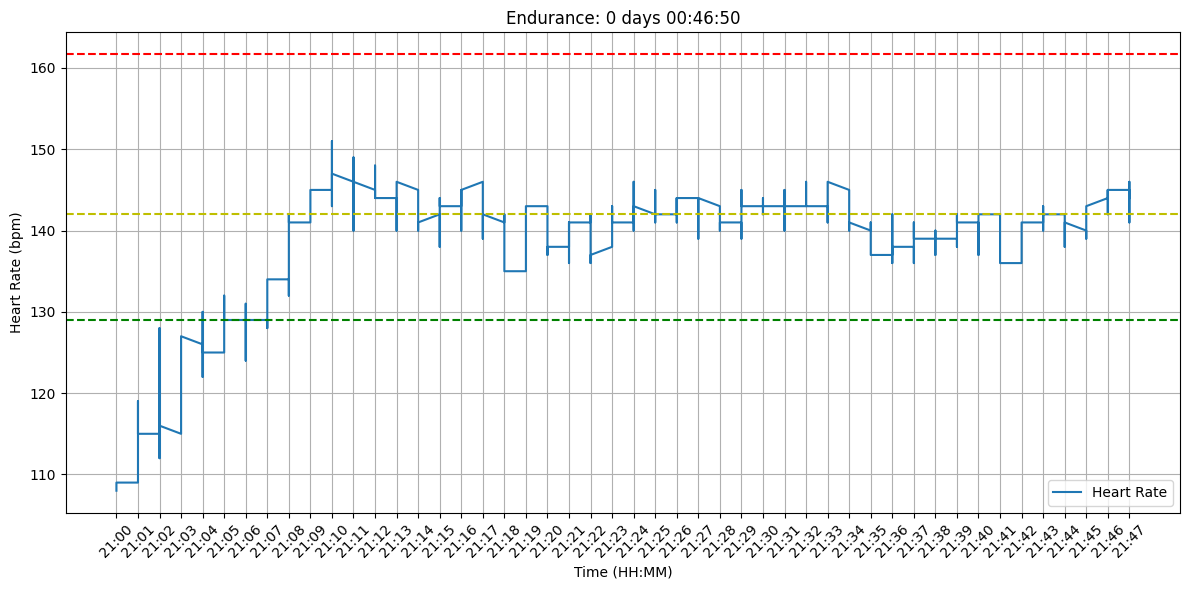

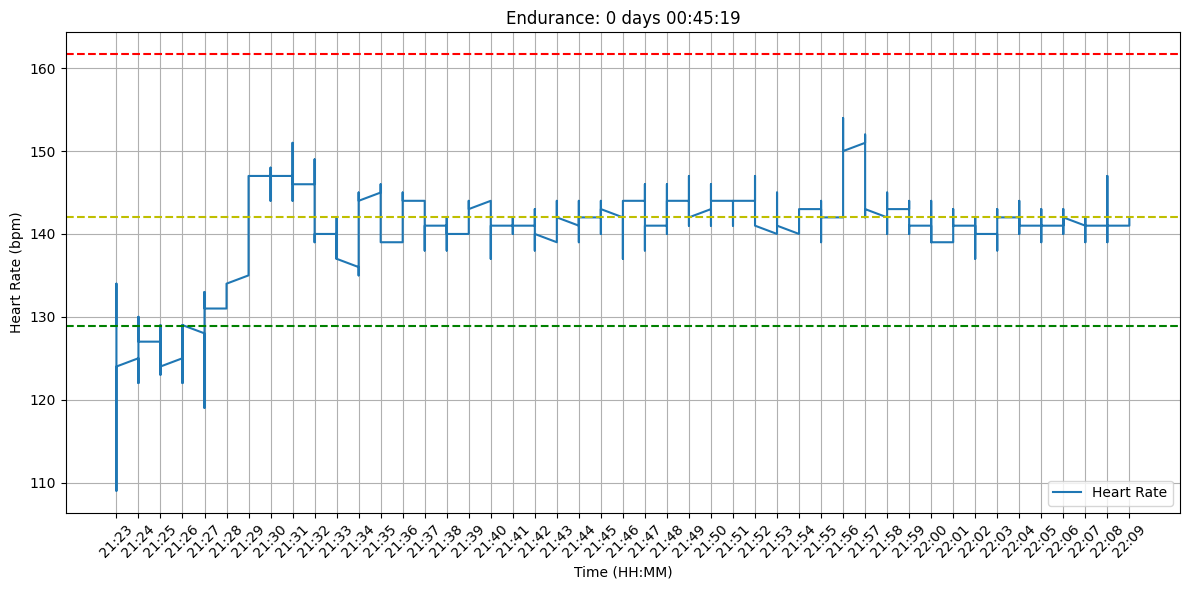

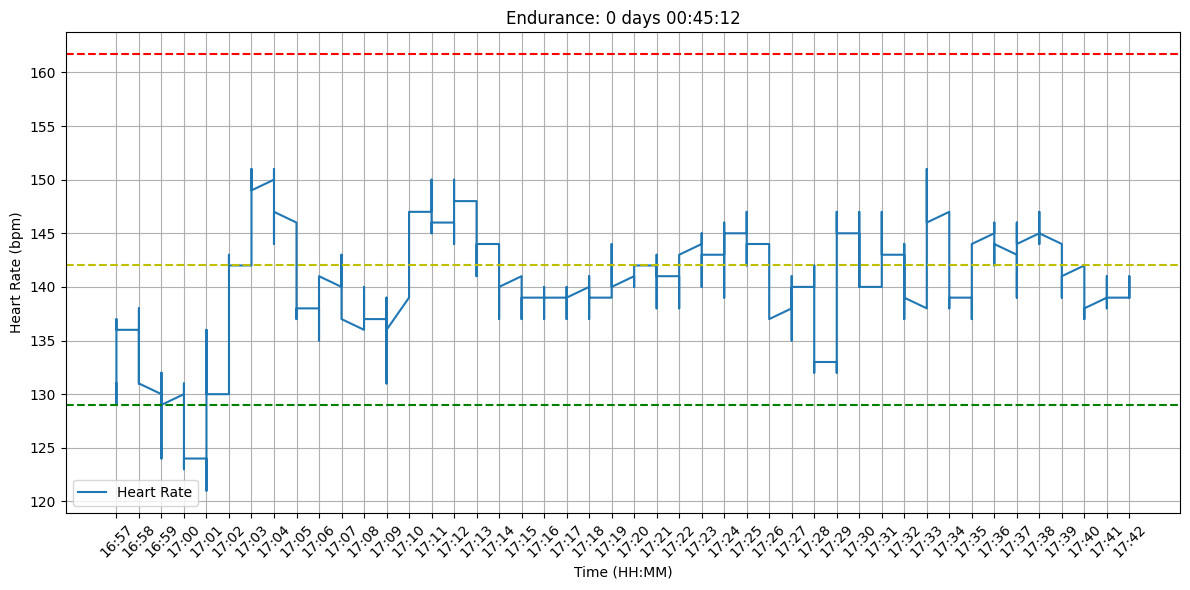

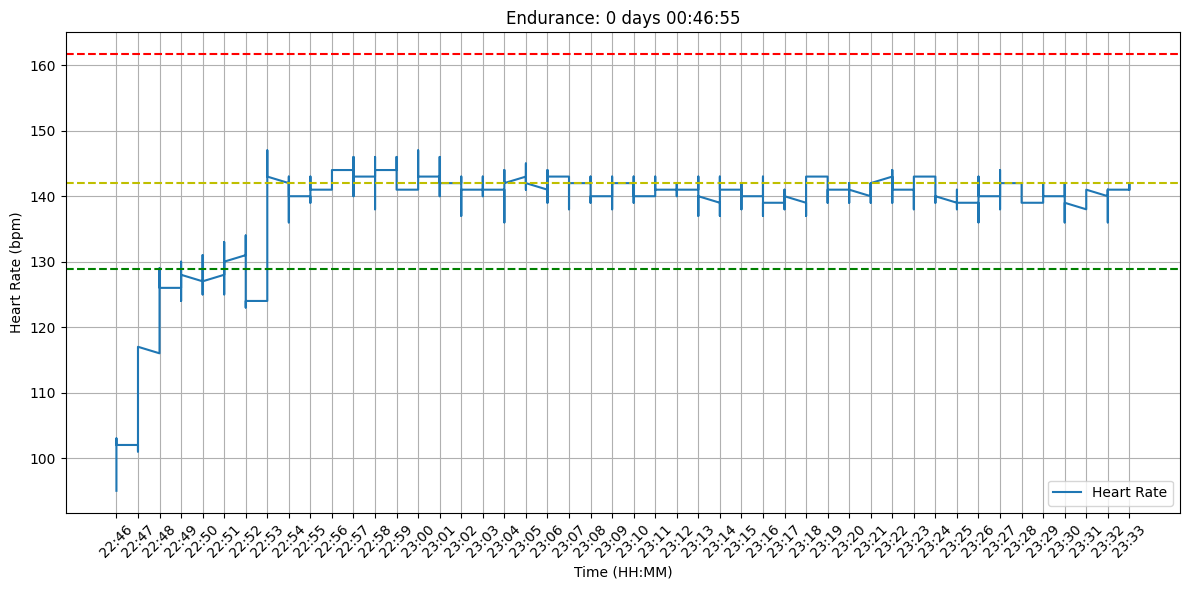

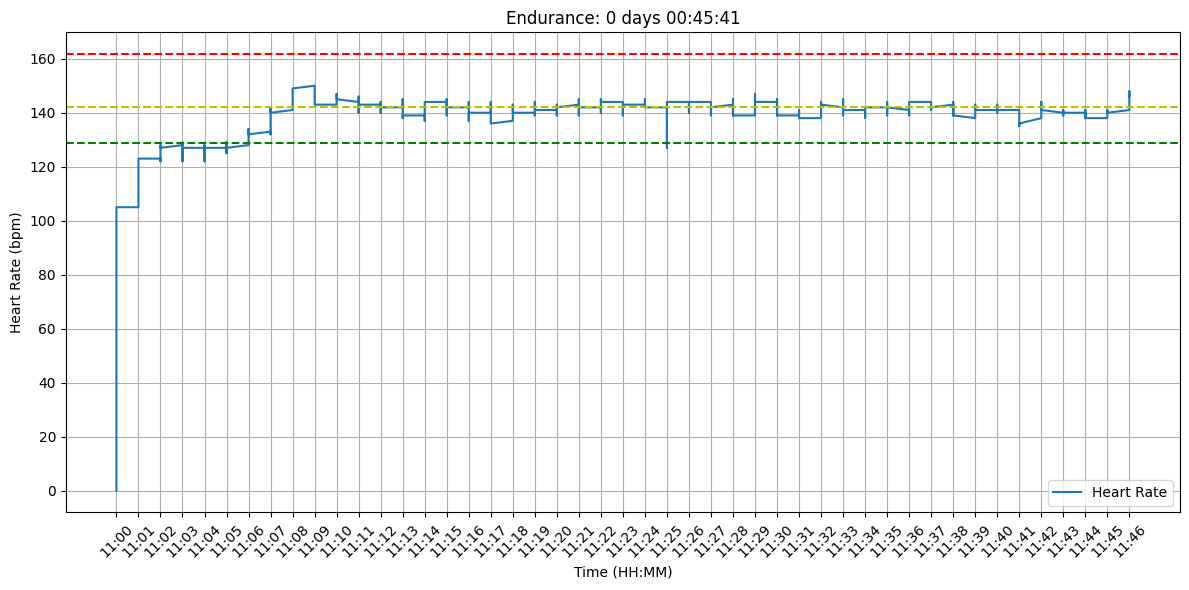

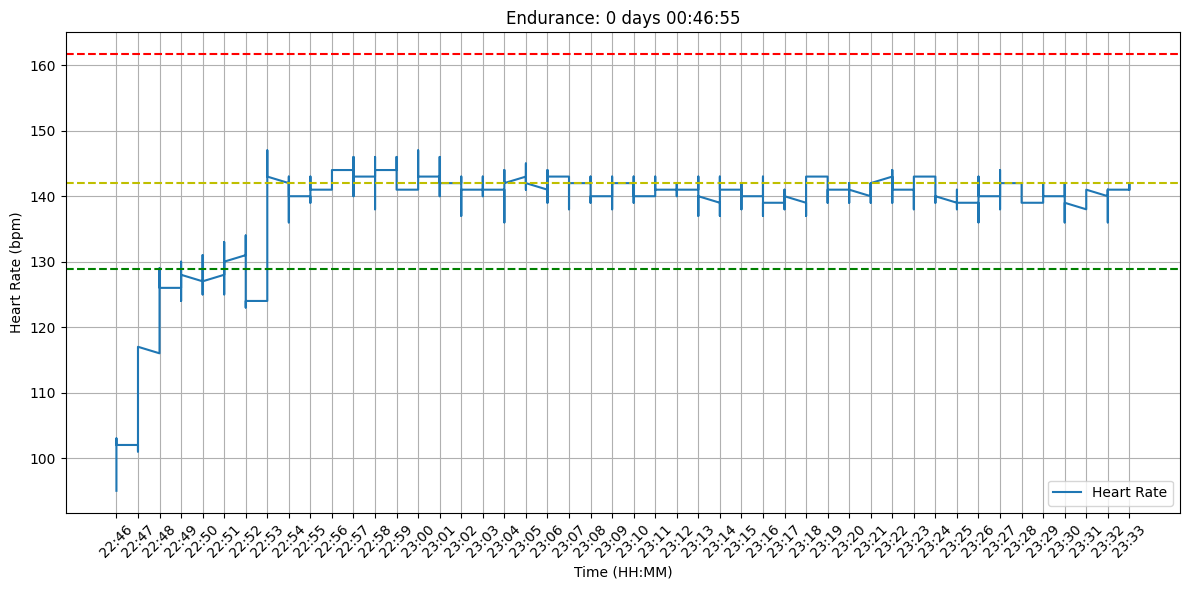

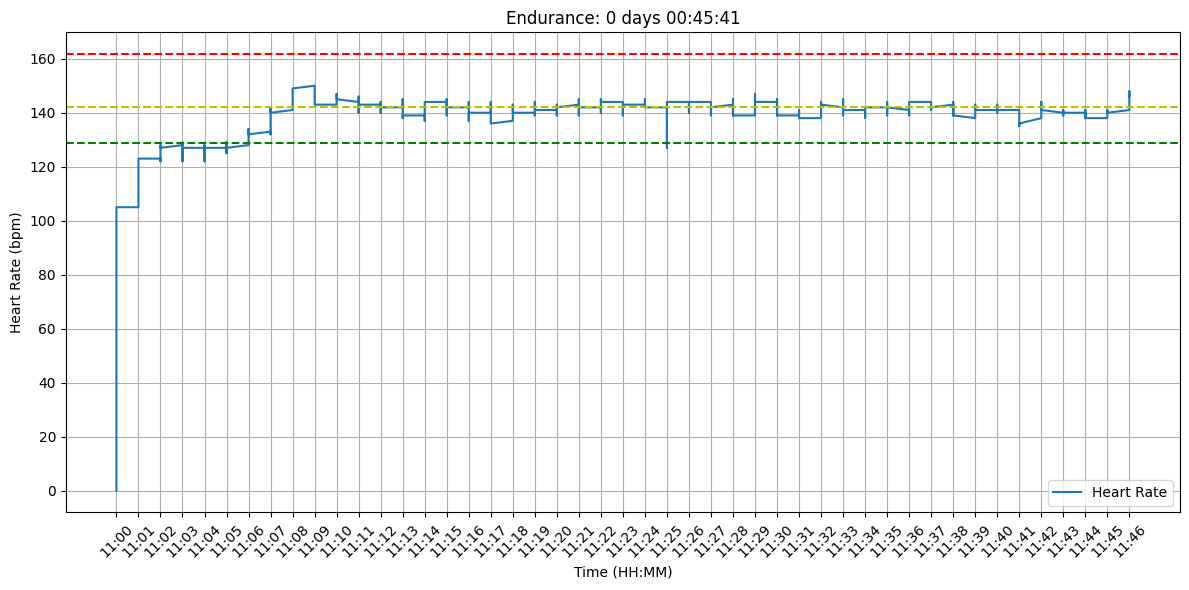

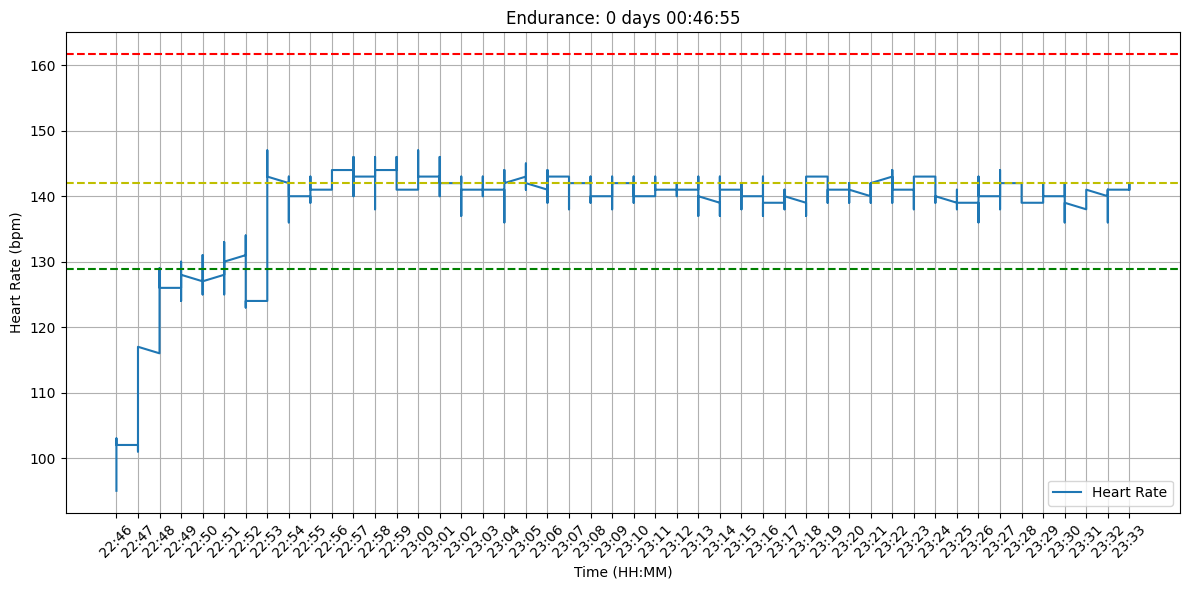

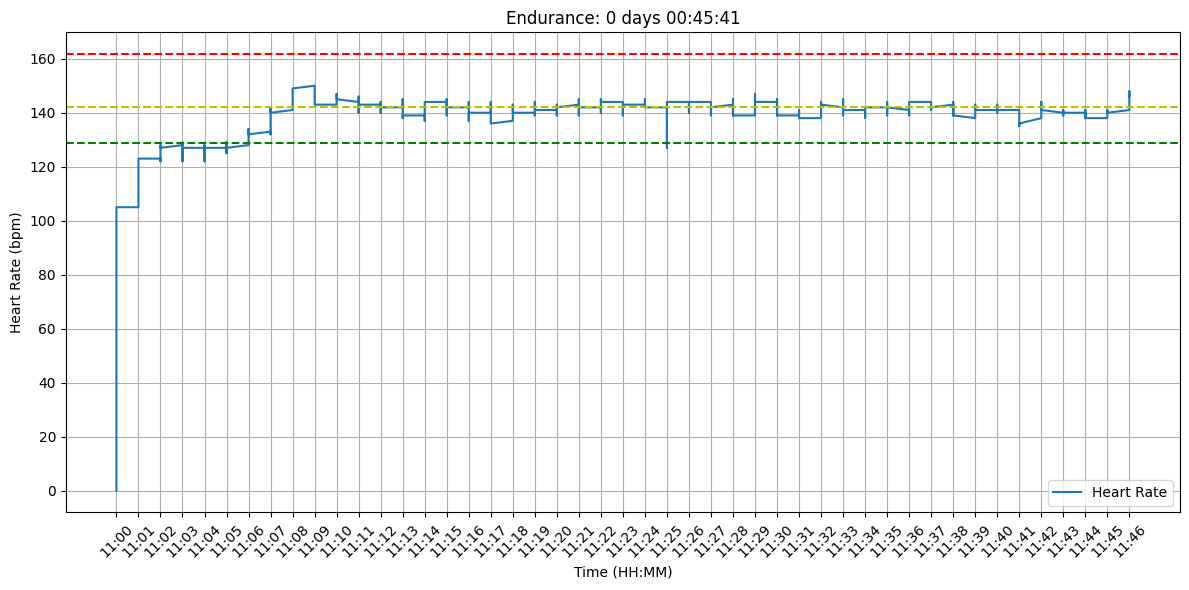

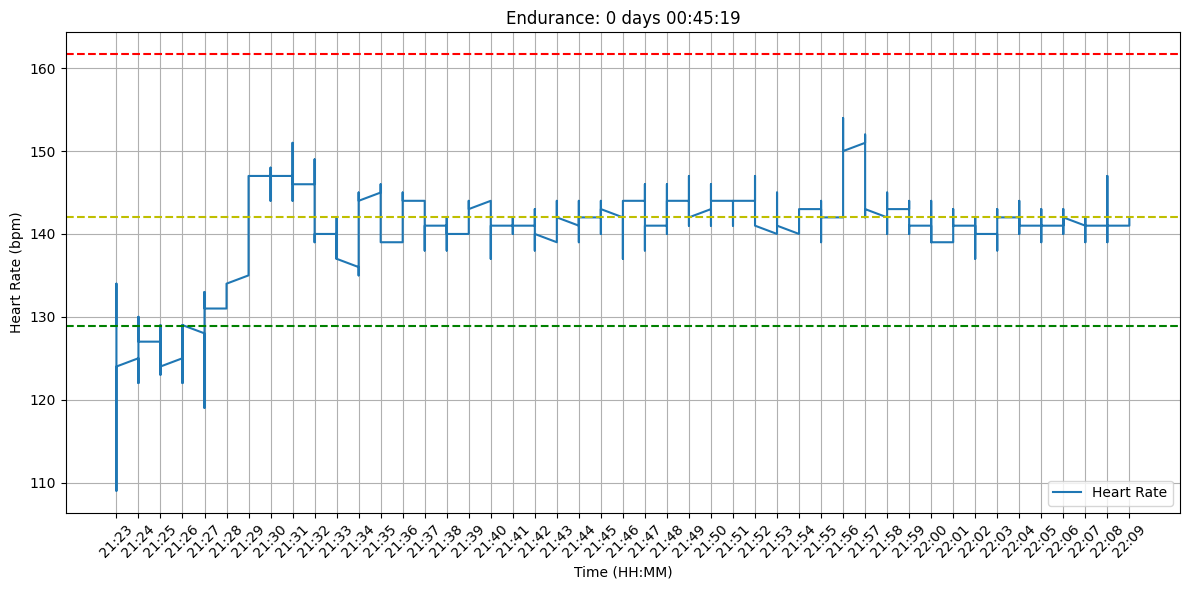

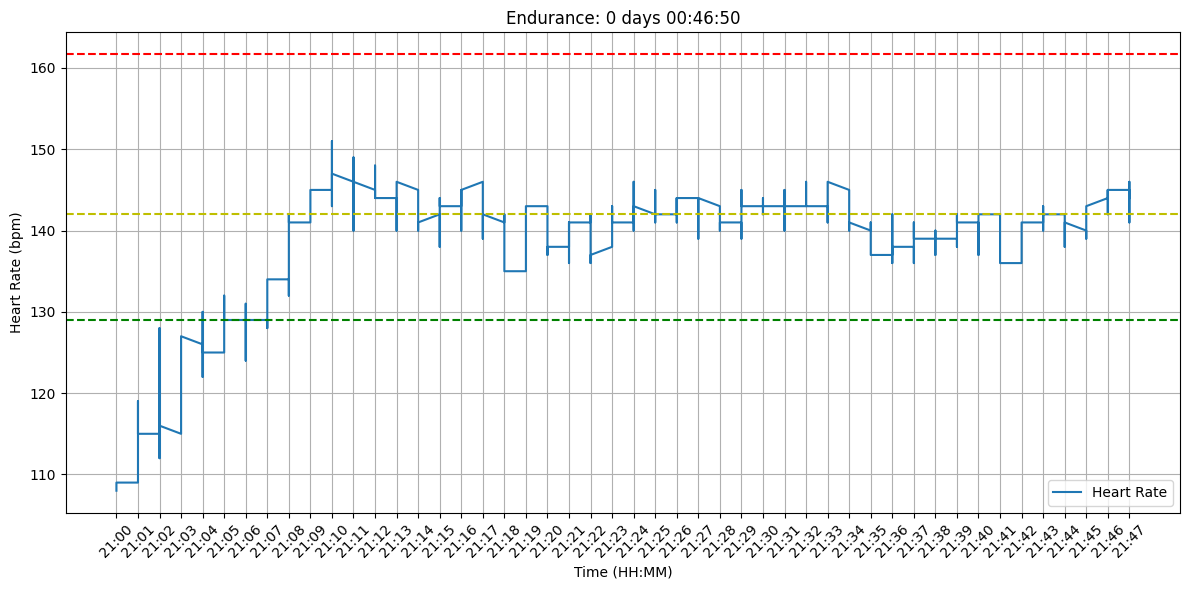

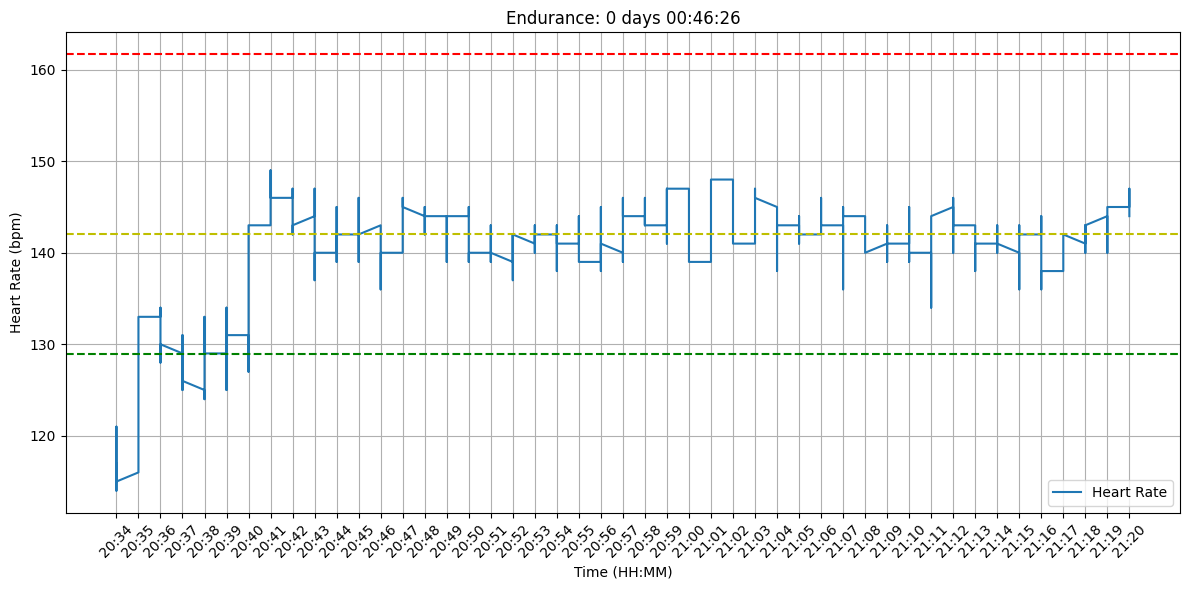

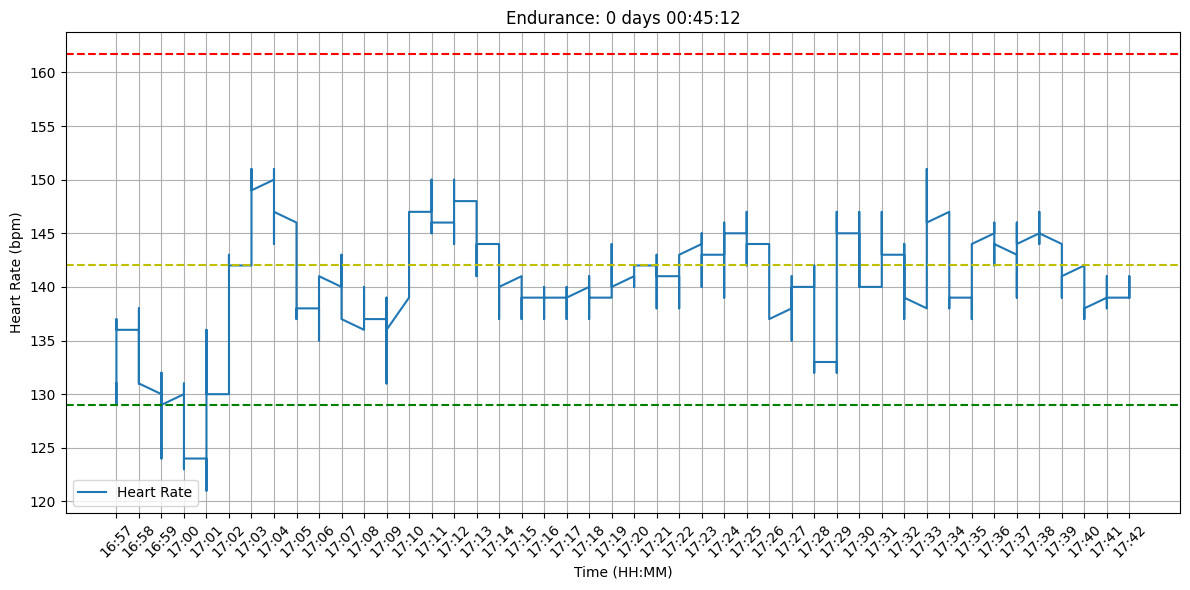

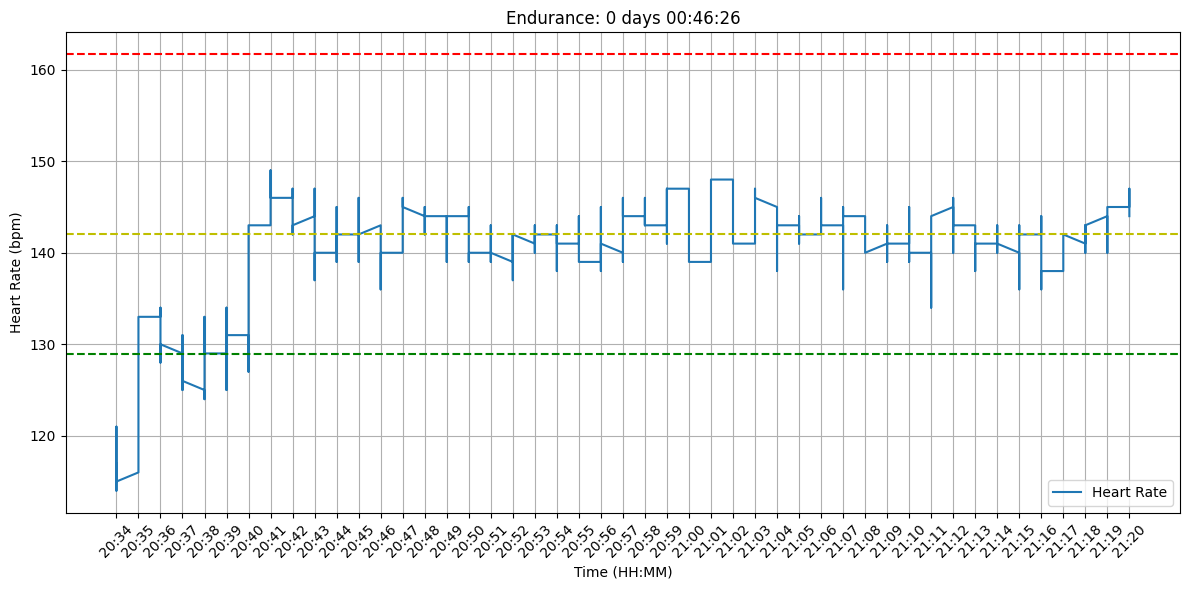

In [586]:
# Plot the QC check files
participant = "046_qtz1b12637499885254663"
base_dir = f"/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/polar/workout/{participant}/"

# Load redcap data
df_path = '/Users/aubreykr/Google Drive/Shared drives/HIIT and Endurance Study/Data/data/Redcap/Raw_Data/64208_HRZones_Raw.csv'
df_red = pd.read_csv(df_path)

ppt= participant.split('_')[1]
participant_info = df_red[df_red['myphd_id'] == ppt]['record_id'].iloc[0]
print(participant_info)

# Pattern to match QC_CHECK files
pattern = os.path.join(base_dir, "*QC-CHECK*.csv")

# Get a list of files that match the pattern
qc_check_files = glob.glob(pattern)

# Print the list of QC_CHECK files
duration=0
for file in qc_check_files:
    df = pd.read_csv(file)

    # Convert 'dateTime' column to datetime objects
    df['dateTime'] = pd.to_datetime(df['dateTime'])

    # Get duration
    duration = df['dateTime'].max() - df['dateTime'].min()

    # Get group
    rand_group = df_red[df_red['myphd_id'] == ppt]['randomization_group'].values[0]

    # Get HR zones
    MICT_lower_val = df_red[df_red['myphd_id'] == ppt]['target_hr_45'].values[0]
    MICT_upper_val = df_red[df_red['myphd_id'] == ppt]['target_hr_55'].values[0]
    HIIT_lower_val = df_red[df_red['myphd_id'] == ppt]['target_hr_70'].values[0]

    # Extract the time in HH:MM format
    df['dateTime'] = df['dateTime'].dt.strftime('%H:%M')

    # Plot the data
    plt.figure(figsize=(12,6))
    plt.plot(df['dateTime'], df['value'], label='Heart Rate')
    plt.xlabel('Time (HH:MM)')
    plt.ylabel('Heart Rate (bpm)')
    plt.title(f'{rand_group}: {duration}')
    plt.axhline(y=MICT_lower_val, color='g', linestyle='--')
    plt.axhline(y=MICT_upper_val, color='y', linestyle='--')
    plt.axhline(y=HIIT_lower_val, color='r', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Unnamed: 0  record_id redcap_event_name            enrollment_status  \
0             1          1   scr_bl_ep_arm_1                Screen failed   
1             2          2   scr_bl_ep_arm_1                Screen failed   
2             3          3   scr_bl_ep_arm_1                    Completed   
3             4          4   scr_bl_ep_arm_1                    Completed   
4             5          5   scr_bl_ep_arm_1                    Completed   
..          ...        ...               ...                          ...   
112         113        123   scr_bl_ep_arm_1  Enrolled (not screened yet)   
113         114        124   scr_bl_ep_arm_1  Enrolled (not screened yet)   
114         115       1070   scr_bl_ep_arm_1          On-going Randomized   
115         116       1076   scr_bl_ep_arm_1          On-going Randomized   
116         117       1091   scr_bl_ep_arm_1          On-going Randomized   

    randomization_group                myphd_id  myphd_date_shift  \
0                   NaN                     NaN               NaN   
1                   NaN                     NaN               NaN   
2             Endurance  qtz1b14715581577341838            2212.0   
3                  HIIT  qtz1b18445579426718188            1607.0   
4             Endurance  qtz1b16767772887265127            1582.0   
..                  ...                     ...               ...   
112                 NaN                     NaN               NaN   
113                 NaN                     NaN               NaN   
114           Endurance                     NaN               NaN   
115             Control                     NaN               NaN   
116             Control                     NaN               NaN   

     target_hr_45  target_hr_55  target_hr_70  target_hr_90  
0            0.00          0.00           0.0           0.0  
1             NaN           NaN           NaN           NaN  
2          116.80        127.20         142.8         163.6  
3          121.25        131.75         147.5         168.5  
4          122.35        132.65         148.1         168.7  
..            ...           ...           ...           ...  
112           NaN           NaN           NaN           NaN  
113           NaN           NaN           NaN           NaN  
114          0.00          0.00           0.0           0.0  
115           NaN           NaN           NaN           NaN  
116          0.00          0.00           0.0           0.0  

[117 rows x 11 columns]

(161.7, 187.9)